
时间步 1:
--------------------------------------------------
节点 1: 类型 = 真实系统, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 3.507, 防御者效用 = -14.003
节点 2: 类型 = 蜜罐, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 0.008, 防御者效用 = 5.985
节点 3: 类型 = 真实系统, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 3.498, 防御者效用 = -14.001
节点 4: 类型 = 蜜罐, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 3.483, 防御者效用 = -10.990
节点 5: 类型 = 真实系统, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 3.502, 防御者效用 = -14.009
节点 6: 类型 = 真实系统, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 3.507, 防御者效用 = -14.010
节点 7: 类型 = 蜜罐, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 3.492, 防御者效用 = -11.010
节点 8: 类型 = 真实系统, 信号 = s2, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 3.490, 防御者效用 = -14.002
节点 9: 类型 = 蜜罐, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = -0.005, 防御者效用 = 5.999
节点 10: 类型 = 真实系统, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 4.486, 防御者效用 = -8.018
节点 11: 类型 = 蜜罐, 信号 = s1, 攻击者信念 = 0.500, 攻击者行为 = attack, 攻击者效用 = 0.018, 防

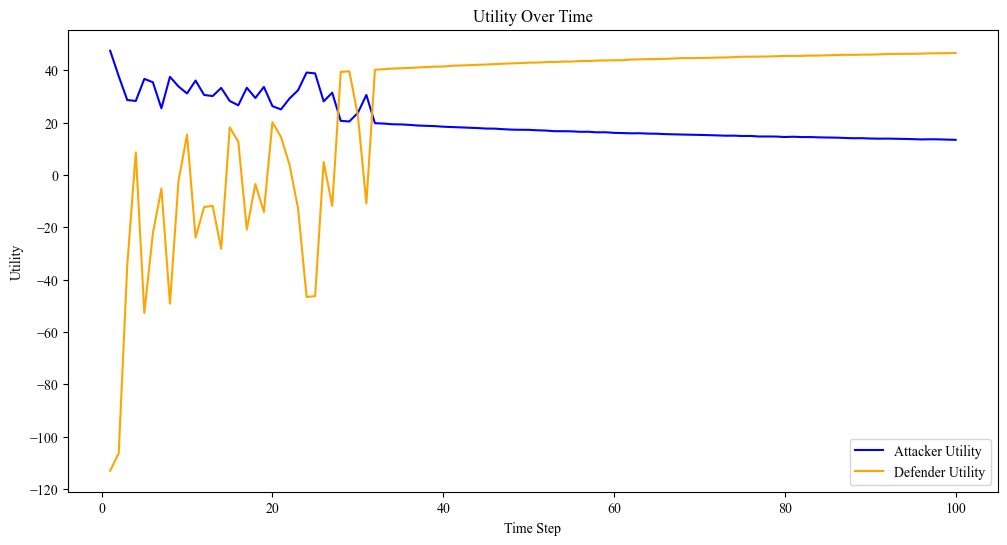

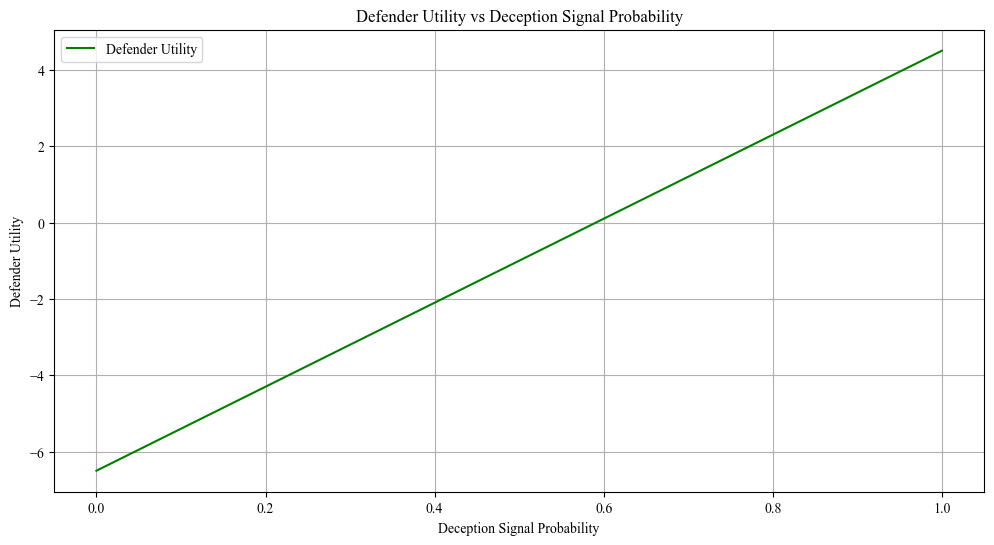

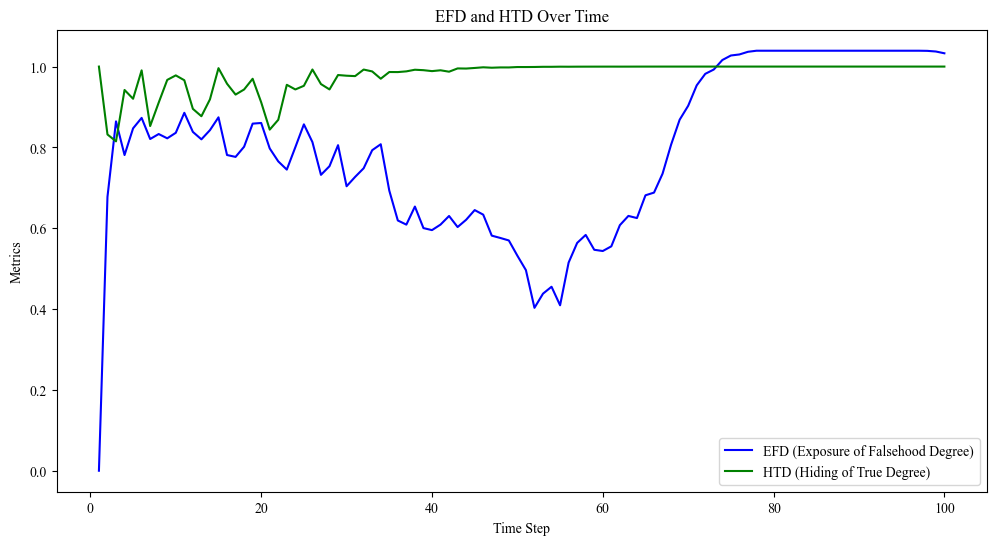

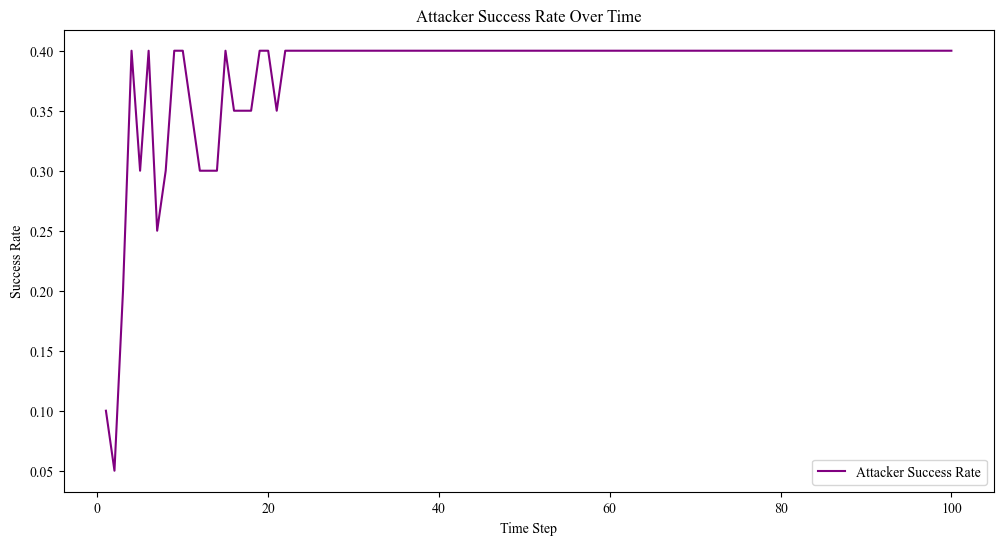

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.spatial.distance import euclidean
from scipy.stats import entropy

# 设置字体为 Times New Roman
font_path = './front_path/Times_New_Roman.ttf'
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.sans-serif'] = 'Times New Roman'

# 初始化参数
Ra_initial = 8  # 攻击者初始奖励
Ca1_initial, Ca2_initial, Ca3 = 2, 3, 6  # 攻击者的初始成本
Co = 1.5  # 攻击者撤退的机会成本
Rds = 6  # 防御者伪装信号的奖励
CH = 5  # 防御者布置蜜罐的成本
Rinf = 5  # 防御者通过影响攻击者信念获得的奖励
Rp = 5  # 攻击者避免被蜜罐捕获的奖励
CDs = 1.5  # 防御者部署伪装的成本
lambda_a = 0.2 # 攻击者奖励衰减因子
lambda_2 = 0.2  # 攻击者成本衰减因子
Rdec_initial = 8  # 防御者初始欺骗奖励
lambda_d = 0.2  # 防御者奖励衰减因子

# 时间步设置
T = 100
N = 20

# 初始信念值
initial_belief = 0.5
beliefs = np.full((N,), initial_belief)

# 信念更新权重参数
δ = 0.3
T_half = T / 2

# 初始化效用和结果
attacker_utilities_t = []
defender_utilities_t = []
belief_history = []
EFD_t = []
HTD_t = []

# 初始化攻击者成功率
success_rates = []

noise_scale_attacker = 0.01
noise_scale_defender = 0.01

# 定义邻居关系
neighbors = {i: [i - 1, i + 1] for i in range(N)}
for i in neighbors:
    neighbors[i] = [n for n in neighbors[i] if 0 <= n < N]

# 初始化防御节点类型
defense_types = np.random.choice([0, 1], size=N, p=[0.5, 0.5])
num_detected = 0
num_probes = 0

for t in range(1, T + 1):
    alpha = 1 / (1 + np.exp(-(t - T_half) / (T / 10)))
    beta = 1 - alpha
    gamma = δ * alpha * (1 - t / T)

    attacker_utility_t = 0
    defender_utility_t = 0
    new_beliefs = np.zeros_like(beliefs)
    efd = 0
    htd = 0
    real_count = 0
    success_count = 0

    print(f"\n时间步 {t}:")
    print("--------------------------------------------------")

    for i in range(N):
        if t == 1:
            # 时间步 1，防御者以固定概率选择信号
            signal = "s1" if np.random.rand() < 0.5 else "s2"
            psi_t_s1 = initial_belief
            psi_t_s2 = initial_belief
            # 初始化 Ra_t 等变量以避免未定义问题
            Ra_t = Ra_initial
            Ca1_t = Ca1_initial
            Ca2_t = Ca2_initial
        else:
            # 计算攻击者信念更新
            phi_theta1_s1 = beliefs[i] * 0.8 / (beliefs[i] * 0.8 + (1 - beliefs[i]) * 0.3)
            phi_theta2_s1 = 1 - phi_theta1_s1
            phi_theta1_s2 = beliefs[i] * 0.2 / (beliefs[i] * 0.2 + (1 - beliefs[i]) * 0.7)
            phi_theta2_s2 = 1 - phi_theta1_s2

            z_actual = 1 if np.random.rand() > 0.5 else 0
            phi_prime_theta1_s1 = phi_theta1_s1 + 0.8 * (z_actual - phi_theta1_s1)
            phi_prime_theta1_s2 = phi_theta1_s2 + 0.8 * (z_actual - phi_theta1_s2)

            neighbor_beliefs = [beliefs[n] for n in neighbors[i]]
            neighbor_weights = np.array([1 / (abs(i - n) + 1) for n in neighbors[i]])
            neighbor_weights /= neighbor_weights.sum()
            psi_neighbor = np.dot(neighbor_weights, neighbor_beliefs)

            psi_t_s1 = alpha * beliefs[i] + beta * phi_prime_theta1_s1 + gamma * psi_neighbor
            psi_t_s2 = alpha * beliefs[i] + beta * phi_prime_theta1_s2 + gamma * psi_neighbor
            psi_t_s1 = max(0, min(1, psi_t_s1))
            psi_t_s2 = max(0, min(1, psi_t_s2))

            if defense_types[i] == 0:
                Ra_t = max(Ra_initial * np.exp(-lambda_a * np.log(t + 1)), 0)
                Ca1_t = max(Ca1_initial * (1 - lambda_2 * min(num_probes, t / 2)), 0)
                Ca2_t = max(Ca2_initial / (1 + lambda_2 * min(num_probes, t / 2)), 0.1)
                EU_D_s1 = psi_t_s1 * (-Ra_t) + psi_t_s2 * Rds - CDs
                EU_D_s2 = psi_t_s2 * (-Ra_t - Rds) + psi_t_s1 * (-CH + Rinf) - CDs
            else:
                Rdec_t = max(Rdec_initial * np.exp(-lambda_d * num_detected), 0)
                EU_D_s1 = psi_t_s1 * (-CH) + psi_t_s2 * (Rp) - CDs
                EU_D_s2 = psi_t_s2 * (-CH - Rds) + psi_t_s1 * (-CH + Rdec_t) - CDs

            if EU_D_s1 > EU_D_s2:
                signal = "s1"
                belief_update = psi_t_s1
            else:
                signal = "s2"
                belief_update = psi_t_s2

        if signal == "s1":
            EU_A_attack = psi_t_s1 * (Ra_t - Ca1_t - Co) + psi_t_s2 * (-CH + Rinf)
            EU_A_retreat = -Co
        else:
            EU_A_attack = psi_t_s2 * (Ra_t - Ca2_t - Co) + psi_t_s1 * (-CH - Rds + Rinf)
            EU_A_retreat = -Co

        if EU_A_attack > EU_A_retreat:
            attacker_action = "attack"
            num_probes += 1
            if signal == "s1":
                if defense_types[i] == 0:
                    attacker_utility = Ra_t - Ca1_t - Co
                    defender_utility = -Ra_t
                    success_count += 1
                else:
                    attacker_utility = -CH + Rinf
                    defender_utility = Rds
            else:
                if defense_types[i] == 0:
                    attacker_utility = Ra_t - Ca2_t - Co
                    defender_utility = -Ra_t - Rds
                else:
                    attacker_utility = -Co + Rp
                    defender_utility = -CH - Rds
        else:
            attacker_action = "retreat"
            attacker_utility = -Co
            if defense_types[i] == 0:
                defender_utility = 0
            else:
                defender_utility = -CH if signal == "s1" else -CH - CDs

        attacker_utility += np.random.normal(0, noise_scale_attacker)
        defender_utility += np.random.normal(0, noise_scale_defender)

        print(f"节点 {i + 1}: 类型 = {'真实系统' if defense_types[i] == 0 else '蜜罐'}, 信号 = {signal}, 攻击者信念 = {beliefs[i]:.3f}, 攻击者行为 = {attacker_action}, 攻击者效用 = {attacker_utility:.3f}, 防御者效用 = {defender_utility:.3f}")

        if t > 1:
            new_beliefs[i] = belief_update
        attacker_utility_t += attacker_utility
        defender_utility_t += defender_utility

        if defense_types[i] == 1:
            f_real = np.array([psi_t_s1, psi_t_s2, beliefs[i]])
            f_deceptive = np.array([1 - psi_t_s1, 1 - psi_t_s2, 1 - beliefs[i]])
            efd += euclidean(f_real, f_deceptive)

        if defense_types[i] == 0:
            p_x = np.array([psi_t_s1, psi_t_s2])
            p_x = p_x / p_x.sum()
            htd += entropy(p_x, base=2)
            real_count += 1

    success_rates.append(success_count / N)
    EFD_t.append(efd / N)
    HTD_t.append(htd / (real_count if real_count > 0 else 1))

    if t > 1:
        beliefs = new_beliefs
    attacker_utilities_t.append(attacker_utility_t)
    defender_utilities_t.append(defender_utility_t)

plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), attacker_utilities_t, label="Attacker Utility", color="blue")
plt.plot(range(1, T + 1), defender_utilities_t, label="Defender Utility", color="orange")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Utility")
plt.title("Utility Over Time")
plt.savefig("utility_over_time_high_dpi.png", dpi=400)
plt.show()

# 绘制防御者收益随伪装信号概率变化的曲线
defender_utilities = []
deception_probs = np.linspace(0, 1, 50)
for p in deception_probs:
    utility = p * Rds - CDs - (1 - p) * CH
    defender_utilities.append(utility)

plt.figure(figsize=(12, 6))
plt.plot(deception_probs, defender_utilities, label="Defender Utility", color="green")
plt.xlabel("Deception Signal Probability")
plt.ylabel("Defender Utility")
plt.title("Defender Utility vs Deception Signal Probability")
plt.legend()
plt.grid()
plt.savefig("defender_utility_vs_deception_probability.png", dpi=400)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), EFD_t, label="EFD (Exposure of Falsehood Degree)", color="blue")
plt.plot(range(1, T + 1), HTD_t, label="HTD (Hiding of True Degree)", color="green")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Metrics")
plt.title("EFD and HTD Over Time")
plt.savefig("efd_htd_over_time_high_dpi.png", dpi=400)
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(1, T + 1), success_rates, label="Attacker Success Rate", color="purple")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Success Rate")
plt.title("Attacker Success Rate Over Time")
plt.savefig("attacker_success_rate_high_dpi.png", dpi=400)
plt.show()